In [1]:
import numpy as np

import matplotlib.pyplot as plt

# python module containing model logic
import twins

%load_ext autoreload
%autoreload 2

%matplotlib inline

plt.rcParams.update(
    {
        "figure.figsize": (12, 6),
        "font.size": 24,
    }
)

In [2]:
datasets = twins.dataset.describe()

course_tags
user_assessment_scores
user_course_views
user_interests


In [3]:
tags = twins.dataset.load("course_tags")
scores = twins.dataset.load("user_assessment_scores")
views = twins.dataset.load("user_course_views")
interests = twins.dataset.load("user_interests")

In [4]:
n_users = [
    len(views.user_handle.unique()),
    len(interests.user_handle.unique()),
    len(scores.user_handle.unique())
]
print(n_users)
# use the largest table and left join to it - assume that is the
# universe of all users for interest of time
print(np.max(n_users))

[8760, 10000, 3114]
10000


# Model - Version 1

I want to do something very quick and very easy for the first pass (not too much time at the moment).

The overall strategy will be to only use the "text" data and treat each user as a collection of courses, assessments, and interests (leaving out tags for now just due to simplicity). From there each user is effectively a "bag of words" and that can be represented by a count vector or some other text processing technique like TF-IDF. I think solution scales relatively well both for training and predicting and allows for sparse encodings if necessary.

This model could be built on a smaller corpus and lends itself to relatively quick training and even predciting without retraining if you wanted. Additionally if a course had tags and and all the info you could even to user-item similarities to make recs.

The steps will be as follows

1. Combine info of users interests, views, assesments into "sentence" for the user.
2. Create a tokenizer from this data (can be used later too) and map to a tf-idf vector.
3. Embed the tf-idf matrix to a lower dimensional space using PCA to get the user vectors. (no sense in directly comparing the full tf-idf matrix)


## Extra thoughts

I wanted to do some sort of CF or NN based model to get the user vectors (based on interactions and such) but didn't feel that was necessary for the first pass.

There is no validation on the model due to time constraints but it would be nice to know how well it does.

In [5]:
train_dat, user_vecs, model = twins.v1.train()

Looks like our smaller vectors don't quite capture all the variance - we could always try another embedding technique of the tf-idf vectors, maybe tsne? - but this seems decent so let's just move on.

32 features captures 52% of the variance


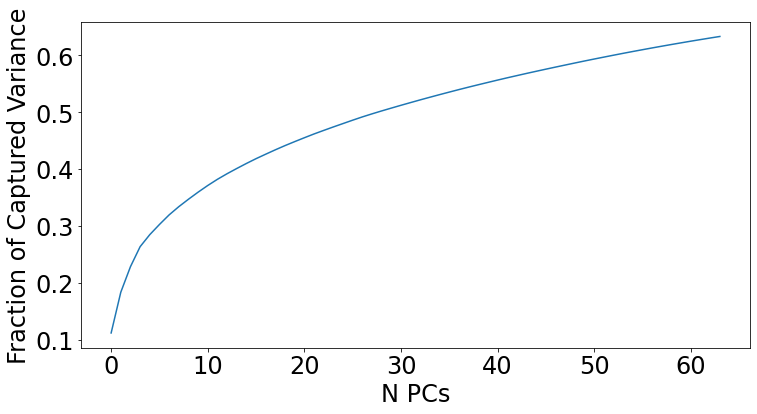

In [6]:
model.plot_explained_variance(32)

Interesting... Looks kind of generally like there two more dominant types of users.

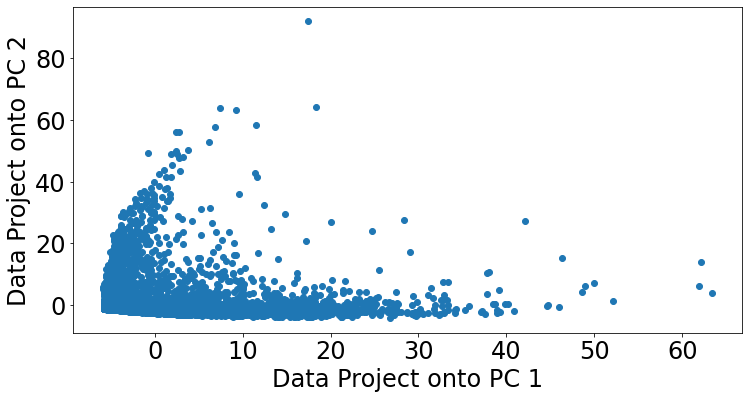

In [7]:
model.plot_pcs(train_dat.sentence.values)

View an example of similar users...

In [8]:
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

sim = cosine_similarity(user_vecs, user_vecs)

def show_similar(sim_mat: np.array, data: pd.DataFrame) -> callable:
    def _show(idx: int, nearest: int = 1) -> None:
        args = np.argsort(sim[idx, :])[::-1]
        vals = np.sort(sim[idx, :])[::-1]
        for i in [idx, args[nearest]]:
            print(f"{i}: {data.loc[i].sentence}\n")
        print(f"similarity: {sim[idx, args[nearest]]}")
    return _show
                 
show = show_similar(sim, train_dat)

In [9]:
show(500)

500: android c# html5 ice-cream-sandwich java javascript javascript-frameworks javascript-libraries nodejs python

7153: android html5 ice-cream-sandwich java javascript javascript-frameworks javascript-libraries

similarity: 0.9876583949174528


In [10]:
show(3001)

3001: 3d-modeling 3d-texturing autocad environment-modeling hard-surface-modeling maya photoshop unreal-engine an-interior-walkthrough-unreal-engine-3ds-max-2157 building-landscape-from-ground-up-world-machine-2313 importing-rendering-stylized-environment-unreal-engine-2234 introduction-lighting-unreal-engine-4-1659 introduction-maya-2016-2054 matlab-fundamentals node-intro quixel-suite-2-ddo-essentials-2527 r-data-analysis r-data-science unreal-engine-4-blueprint-cplusplus-integration unreal-engine-4-blueprints-fundamentals unreal-engine-4-materials-fundamentals autocad

2715: 3d-animation 3d-dynamics 3d-lighting 3d-modeling 3d-rendering after-effects environment-modeling game-art game-design game-modeling maya mental-ray photoshop unreal-engine virtual-reality cloth-workflows-zbrush-1557 importing-rendering-stylized-environment-unreal-engine-2234 introduction-ncloth-maya-860 introduction-unreal-engine-4-1609 unreal-engine-4-materials-fundamentals using-cloth-simulations-mechanical-ri